# Investigate the No-show Appointments Dataset
## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction
>This dataset collects data from some medical appointments in Brazil and is focused on the questions of whether or not patients show up for their appointments. A number of characteristics about the patients are included in each row. I try to explore the relationship between patients' showing-up and their personal information to see whether the patients' showing-up is predictable.
>
>The questions I would like to look at are:
 1. Whether or not the patient is enrolled in Brasilian welfare program has something to do with their showing up?
 2. Does the number of messages sent to the patients have a relationship with their attendence of medical appointments? 
 3. Can we use the length of the time between patients made an appointment and the appointment to predict their showing up?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df=pd.read_csv('noshowappointments-kagglev2-may-2016.csv')

<a id='wrangling'></a>
## Data Wrangling

### General Properties

In [3]:
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [4]:
df.shape

(110527, 14)

In [5]:
df.info() #check for null data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [6]:
df.duplicated().sum() #check for duplicate data

0

>From the above data properties, we know that there are no NaN numbers or duplicates in the dataset. The only thing that might need to change is the data types of 'ScheduledDay' and 'AppointmentDay'.

### Adjusting Data Types

In [7]:
# Change the data type of 'SchedueledDay' from string into datetime
df.ScheduledDay = pd.to_datetime(df['ScheduledDay'], format="%Y-%m-%dT%H:%M:%SZ")
df['ScheduledDay_new']=df.ScheduledDay.apply(lambda x: x.date()) # For the convenience of operation with 'AppointmentDay'

In [8]:
# Change the 'AppointmentDay' column into datetime
df.AppointmentDay = pd.to_datetime(df['AppointmentDay'], format="%Y-%m-%dT%H:%M:%SZ")
df['AppointmentDay_new']=df.AppointmentDay.apply(lambda x: x.date())

In [9]:
# Check for the change
df.dtypes

PatientId                    float64
AppointmentID                  int64
Gender                        object
ScheduledDay          datetime64[ns]
AppointmentDay        datetime64[ns]
Age                            int64
Neighbourhood                 object
Scholarship                    int64
Hipertension                   int64
Diabetes                       int64
Alcoholism                     int64
Handcap                        int64
SMS_received                   int64
No-show                       object
ScheduledDay_new              object
AppointmentDay_new            object
dtype: object

In [10]:
df.tail()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,ScheduledDay_new,AppointmentDay_new
110522,2.572134e+12,5651768,F,2016-05-03 09:15:35,2016-06-07,56,MARIA ORTIZ,0,0,0,0,0,1,No,2016-05-03,2016-06-07
110523,3.596266e+12,5650093,F,2016-05-03 07:27:33,2016-06-07,51,MARIA ORTIZ,0,0,0,0,0,1,No,2016-05-03,2016-06-07
110524,1.557663e+13,5630692,F,2016-04-27 16:03:52,2016-06-07,21,MARIA ORTIZ,0,0,0,0,0,1,No,2016-04-27,2016-06-07
110525,9.213493e+13,5630323,F,2016-04-27 15:09:23,2016-06-07,38,MARIA ORTIZ,0,0,0,0,0,1,No,2016-04-27,2016-06-07
110526,3.775115e+14,5629448,F,2016-04-27 13:30:56,2016-06-07,54,MARIA ORTIZ,0,0,0,0,0,1,No,2016-04-27,2016-06-07


<a id='eda'></a>
## Exploratory Data Analysis

### Exploration for the correlation matrix of the multiple variables

In [123]:
df[['Age','Scholarship','Hipertension','Diabetes','Alcoholism','Handcap','SMS_received']].corr()

,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
Age,1.000000,-0.092457,0.504586,0.292391,0.095811,0.078033,0.012643
Scholarship,-0.092457,1.000000,-0.019729,-0.024894,0.035022,-0.008586,0.001194
Hipertension,0.504586,-0.019729,1.000000,0.433086,0.087971,0.080083,-0.006267
Diabetes,0.292391,-0.024894,0.433086,1.000000,0.018474,0.057530,-0.014550
Alcoholism,0.095811,0.035022,0.087971,0.018474,1.000000,0.004648,-0.026147
Handcap,0.078033,-0.008586,0.080083,0.057530,0.004648,1.000000,-0.024161
SMS_received,0.012643,0.001194,-0.006267,-0.014550,-0.026147,-0.024161,1.000000


> Any two variables in the table are not strongly correlated.
>
>Patients' hipertension data has a moderate correlation with age data (correlation coefficient=0.5) and diabetes data (correlation coefficient=0.43).
>
>The data have limitations for showing strong correlations as most of the data are categorical.

### Q1: Whether or not the patient is enrolled in Brasilian welfare program has something to do with their showing up?

In [11]:
# The ratio of number of showing up:number of total appointments for the people who do not have scholarship
df_no=df.query('Scholarship==0')['No-show'].value_counts()/df.query('Scholarship==0')['No-show'].count()
df_no

No     0.801928
Yes    0.198072
Name: No-show, dtype: float64

In [12]:
# The ratio of number of showing up:number of total appointments for the people who have scholarship
df_yes=df.query('Scholarship==1')['No-show'].value_counts()/df.query('Scholarship==1')['No-show'].count()
df_yes

No     0.762637
Yes    0.237363
Name: No-show, dtype: float64

> As I want to compare the showing up rate of the patients in the welfare program to that of those not in the welfare program, I choose to plot the two data in a bar graph.

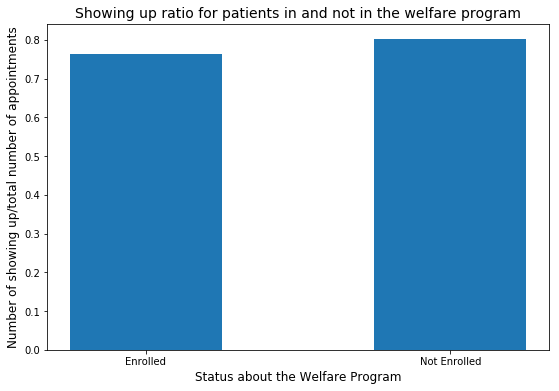

In [52]:
#Visualize the showing up ratio for the two groups of people (people in and not in the welfare program)
x=['Enrolled','Not Enrolled']
plt.subplots(figsize=(9,6))
plt.bar(x,[df_yes[0],df_no[0]],width=0.5)
plt.xlabel("Status about the Welfare Program",size=12) 
plt.ylabel("Number of showing up/total number of appointments",size=12) 
plt.title("Showing up ratio for patients in and not in the welfare program",size=14);

> From the bar graph, we can see that the showing up ratio of patients outside the welfare program is slightly higher than patients in the program.

### Q2: Does the number of messages sent to the patients have a relationship with their attendence of medical appointments?

In [14]:
# check for the SMS data
df.SMS_received.value_counts()

0    75045
1    35482
Name: SMS_received, dtype: int64

In [15]:
# Calculated the number of people showing and no-show when they received or did not receive messages
df_SMS=df.groupby('SMS_received')['No-show'].value_counts()/df.groupby('SMS_received')['No-show'].count()
df_SMS

SMS_received  No-show
0             No         0.832967
              Yes        0.167033
1             No         0.724255
              Yes        0.275745
Name: No-show, dtype: float64

> As I want to compare the showing up rate of the patients received message to that of patients without message, I choose to plot the two data in a bar graph again.

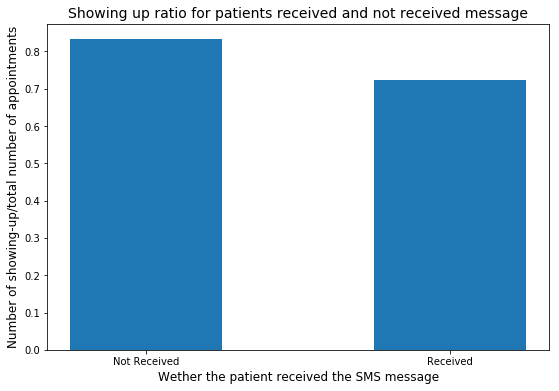

In [53]:
x=['Not Received','Received']
plt.subplots(figsize=(9,6))
plt.bar(x,[df_SMS[0][0],df_SMS[1][0]],width=0.5)
plt.xlabel("Wether the patient received the SMS message",size=12) 
plt.ylabel("Number of showing-up/total number of appointments",size=12) 
plt.title("Showing up ratio for patients received and not received message",size=14);

> We can see that the showing up ratio of patients who received message is lower than patients who not, which is quite counter intuitive.

### Q3: Can we use the waiting time between patients made an appointment and the appointment to predict their showing up?

In [17]:
# Create a column for the time between booking an appointment and the appointment
df['Waiting_time']=df['AppointmentDay_new']-df['ScheduledDay_new']
df.Waiting_time.value_counts()

0 days      38563
2 days       6725
4 days       5290
1 days       5213
7 days       4906
6 days       4037
5 days       3277
14 days      2913
3 days       2737
8 days       2332
21 days      1861
28 days      1706
13 days      1682
9 days       1605
15 days      1503
10 days      1391
20 days      1187
22 days      1173
16 days      1151
12 days      1115
17 days      1107
29 days      1089
19 days      1044
18 days      1021
27 days      1013
11 days       987
35 days       963
23 days       822
34 days       808
26 days       731
            ...  
109 days        5
98 days         5
95 days         5
111 days        5
112 days        5
102 days        4
119 days        4
96 days         4
105 days        4
-1 days         4
92 days         3
122 days        3
94 days         2
110 days        2
107 days        2
97 days         2
93 days         2
115 days        2
117 days        1
127 days        1
151 days        1
125 days        1
126 days        1
101 days        1
82 days   

>The are some strange data where the waiting time is negative, so I pull out one of those to see the reason.

In [18]:
#check for weird data
df[df['Waiting_time']=='-6 days']

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,ScheduledDay_new,AppointmentDay_new,Waiting_time
71533,9.982316e+14,5686628,F,2016-05-11 13:49:20,2016-05-05,81,SANTO ANTÔNIO,0,0,0,0,0,0,Yes,2016-05-11,2016-05-05,-6 days


>The reason for the negative waiting time is that patients set the appointment to a day in the past, so that they'll never make it.

In [19]:
# Explore the mean of waiting days for no-show people
df[df['No-show']=='Yes'].Waiting_time.describe()

count                      22319
mean     15 days 19:57:20.638021
std      16 days 14:32:30.776778
min            -6 days +00:00:00
25%              4 days 00:00:00
50%             11 days 00:00:00
75%             23 days 00:00:00
max            179 days 00:00:00
Name: Waiting_time, dtype: object

In [20]:
# Explore the mean of waiting days for showing up people
df[df['No-show']=='No'].Waiting_time.describe()

count                      88208
mean      8 days 18:06:42.575730
std      14 days 13:12:34.372311
min              0 days 00:00:00
25%              0 days 00:00:00
50%              2 days 00:00:00
75%             12 days 00:00:00
max            179 days 00:00:00
Name: Waiting_time, dtype: object

>From the descriptive data of the waiting time of the no-show group and the showing group, we can see the distributions of waiting time in the two groups have distinct differences. So, I try to plot the histograms for the waiting time to visualize such differences.

In [21]:
#change the 'date' type data to integers for plotting
df['Waiting_time_plt']=df['Waiting_time'].astype(str).apply(lambda x:int(x[:2]))

In [22]:
#check the data type
df.Waiting_time_plt.dtypes

dtype('int64')

>Now the waiting time has successfully been changed to integers from dates.

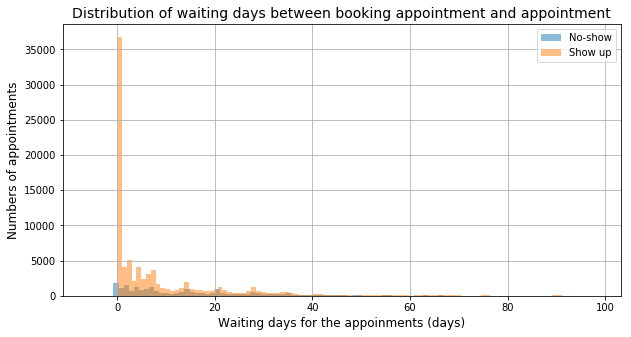

In [128]:
# Visualize the distribution of waiting days for no-show people
plt.subplots(figsize=(10,5))
df[df['No-show']=='Yes'].Waiting_time_plt.hist(alpha=.5,bins=100,label='No-show')
df[df['No-show']=='No'].Waiting_time_plt.hist(alpha=.5,bins=100,label='Show up')
plt.xlabel('Waiting days for the appoinments (days)',size=12)
plt.ylabel('Numbers of appointments',size=12)
plt.title('Distribution of waiting days between booking appointment and appointment',size=14)
plt.legend();

>For the convenience of comparison, I plot the two histograms in one picture.
>By adjusting the number of bins, changes can be made to the histogram. 
>It is clear that the same-day appointments have very low no-show rate.

<a id='conclusions'></a>
## Conclusions

### Q1: Whether or not the patient is enrolled in Brasilian welfare program has something to do with their showing up?


>**Results**:
>1. Among the patients who were enrolled in the Brasilian welfare program, there were 76.26% of them showing up after they made a medical appointment.
>
>2. Among the patients who were not enrolled in the Brasilian welfare program, there were 80.19% of them showing up after they set up an appointment.
>
>3. The percentage of showing up of people in the welfare program is slightly lower than that of people not in the welfare program.The difference is not big, so whether or not the patient is enrolled in Brasilian welfare program may not be a major factor to their showing up.

>**Limitations**:
>
> As some patients have a lot more appointments then the rest of the samples, their personal factor might influence their showing up. 

### Q2: Does the number of messages sent to the patients have a relationship with their attendence of medical appointments?

>**Results:**
>
>1. Among the people who did not receive message, 83.3% of them showed up.
>
>2. Among the people who received 1 message, 72.4% of them showed up.
>
>3. There seems a negative effect of SMS message.

>**Limitations:**
>
>Jumping into conclusion about the effect of SMS messages is not appropriate merely based on the current data.
>
>The relationship between message sending and patients' attendance needs further exploration. How and when were the messages sent to patients? The content of message should also be checked.

### Q3: Can we use the waiting time between patients made an appointment and the appointment to predict their showing up?

>**Results:**
>
> 1. The average waiting time for no-show people is about 15 days sand 20 hours, which is longer than people showing up (8 days and 18 hours).
>
> 2. The appoinments with negative waiting time never had patients show up on time. It is obvous that those patients failed to set up the right time for appointments. I suggest updating the booking system to get rid of such problems.
>
>3. From the histograms about waiting time distribution, we can see that for the appointments with short waiting time,for example, within 3 days, most appoinments ended up with patients' showing up.
>
>4. The waiting time can be used to predict if a patient will show up for their scheduled appointment. If the waiting time is less than 3 days, the patient is highly likely to show up.

>**Limitations:**
>
> As the data in 'AppointmentDay' column are rounded to days, I trimmed the data in 'ScheduledDay' column to days. Such change made it convenient for calculation at the cost of data accuracy.